<a name='начало'></a>

# Spooky Author Identification

* [Начало](#начало)
* [Стратегия](#strategy)
* [Почистване на данните](#cleaning)
    * [Tokenization](#tokenization)
    * [Stop words](#stopwords)
    * [Lemmatization](#lemmatization)
* [Feature engineering](#feature)
    * ['Creative' FE](#creative)
    * [LDA/NMF](#lda)
* [Трениране на модели](#model)
* [Submission](#submit)
* [Заключение](#conclusion)

In [1]:
# Всички import-и на едно място
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from nltk.corpus import stopwords
from IPython.display import display
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation,NMF
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import TruncatedSVD

%matplotlib inline

In [2]:
train = pd.read_csv('data\\train.csv', index_col='id')

<a name='strategy'></a>

## Стратегия

Начинът, по който ще подходя е следният: 
* Почистване на всички текстове
* 'creative' feature engineering
* Намиране на общи теми чрез LDA/NMF

Т.е., ще се опитам да направя нещата, за които Лъчо спомена, но той самият не направи, и ще добавя малко и от себе си.


<a name='cleaning'></a>

## Почистване на данните

<a name='tokenization'></a>

### Tokenization

Искам да махна всички препинателни знаци и текстовете да останат само от думи(съставени от малки букви) разделени със шпации.

С долния регулярен израз ще хвана всички думи и всички думи от вида _дума'дума_, защото не искам _he's_ да ми го цепи на _he_ и _s_.

In [3]:
tokenizer = RegexpTokenizer(r"\w+\'{0,1}\w+")
train.text = train.text.apply(lambda x:" ".join(tokenizer.tokenize(x.lower().strip()))) 

In [4]:
train.head()

,text,author
id,,
id26305,this process however afforded me no means of a...,EAP
id17569,it never once occurred to me that the fumbling...,HPL
id11008,in his left hand was gold snuff box from which...,EAP
id27763,how lovely is spring as we looked from windsor...,MWS
id12958,finding nothing else not even gold the superin...,HPL


<a name='stopwords'></a>

### Stop words

Ще премахна и всички stop words.
Премахвам и тези от френския език, защото видях, че има и текстове с френски думи.

In [5]:
stop_words = stopwords.words('english') + stopwords.words('french')
train.text = train.text.apply(lambda x:" ".join([y for y in x.split() if not y in stop_words]))

In [6]:
train.head()

,text,author
id,,
id26305,process however afforded means ascertaining di...,EAP
id17569,never occurred fumbling might mere mistake,HPL
id11008,left hand gold snuff box capered hill cutting ...,EAP
id27763,lovely spring looked windsor terrace sixteen f...,MWS
id12958,finding nothing else even gold superintendent ...,HPL


<a name='lemmatization'></a>

### Lemmatization

Ще ползвам lemmatization вместо stemming, защото според мен lemmatization прави по смислени неща, а и запазва думите в нормален четим вид.

Този начин, по който правя лематизацията, не е най-добрият, защото има думи, които според контекста могат да са или noun или verb например, а така аз давам някакъв приоритет на нещата според това с кой таг ще викна първо функцията, но мисля, че малък процент от думите ще бъдат объркани и смятам, че няма да е фатално и мога да си го позволя.

In [7]:
lmtzr = WordNetLemmatizer()
train.text = train.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'n') for y in x.split()]))
train.text = train.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'v') for y in x.split()]))
train.text = train.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'a') for y in x.split()]))
train.text = train.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'s') for y in x.split()]))
train.text = train.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'r') for y in x.split()]))

In [8]:
train.head()

,text,author
id,,
id26305,process however afford mean ascertain dimensio...,EAP
id17569,never occur fumble might mere mistake,HPL
id11008,leave hand gold snuff box caper hill cut manne...,EAP
id27763,lovely spring look windsor terrace sixteen fer...,MWS
id12958,find nothing else even gold superintendent aba...,HPL


Нека да видим кои са най-популярните думи след цялото това почистване на текстовете.

In [9]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()

In [10]:
sns.set(font_scale=5)

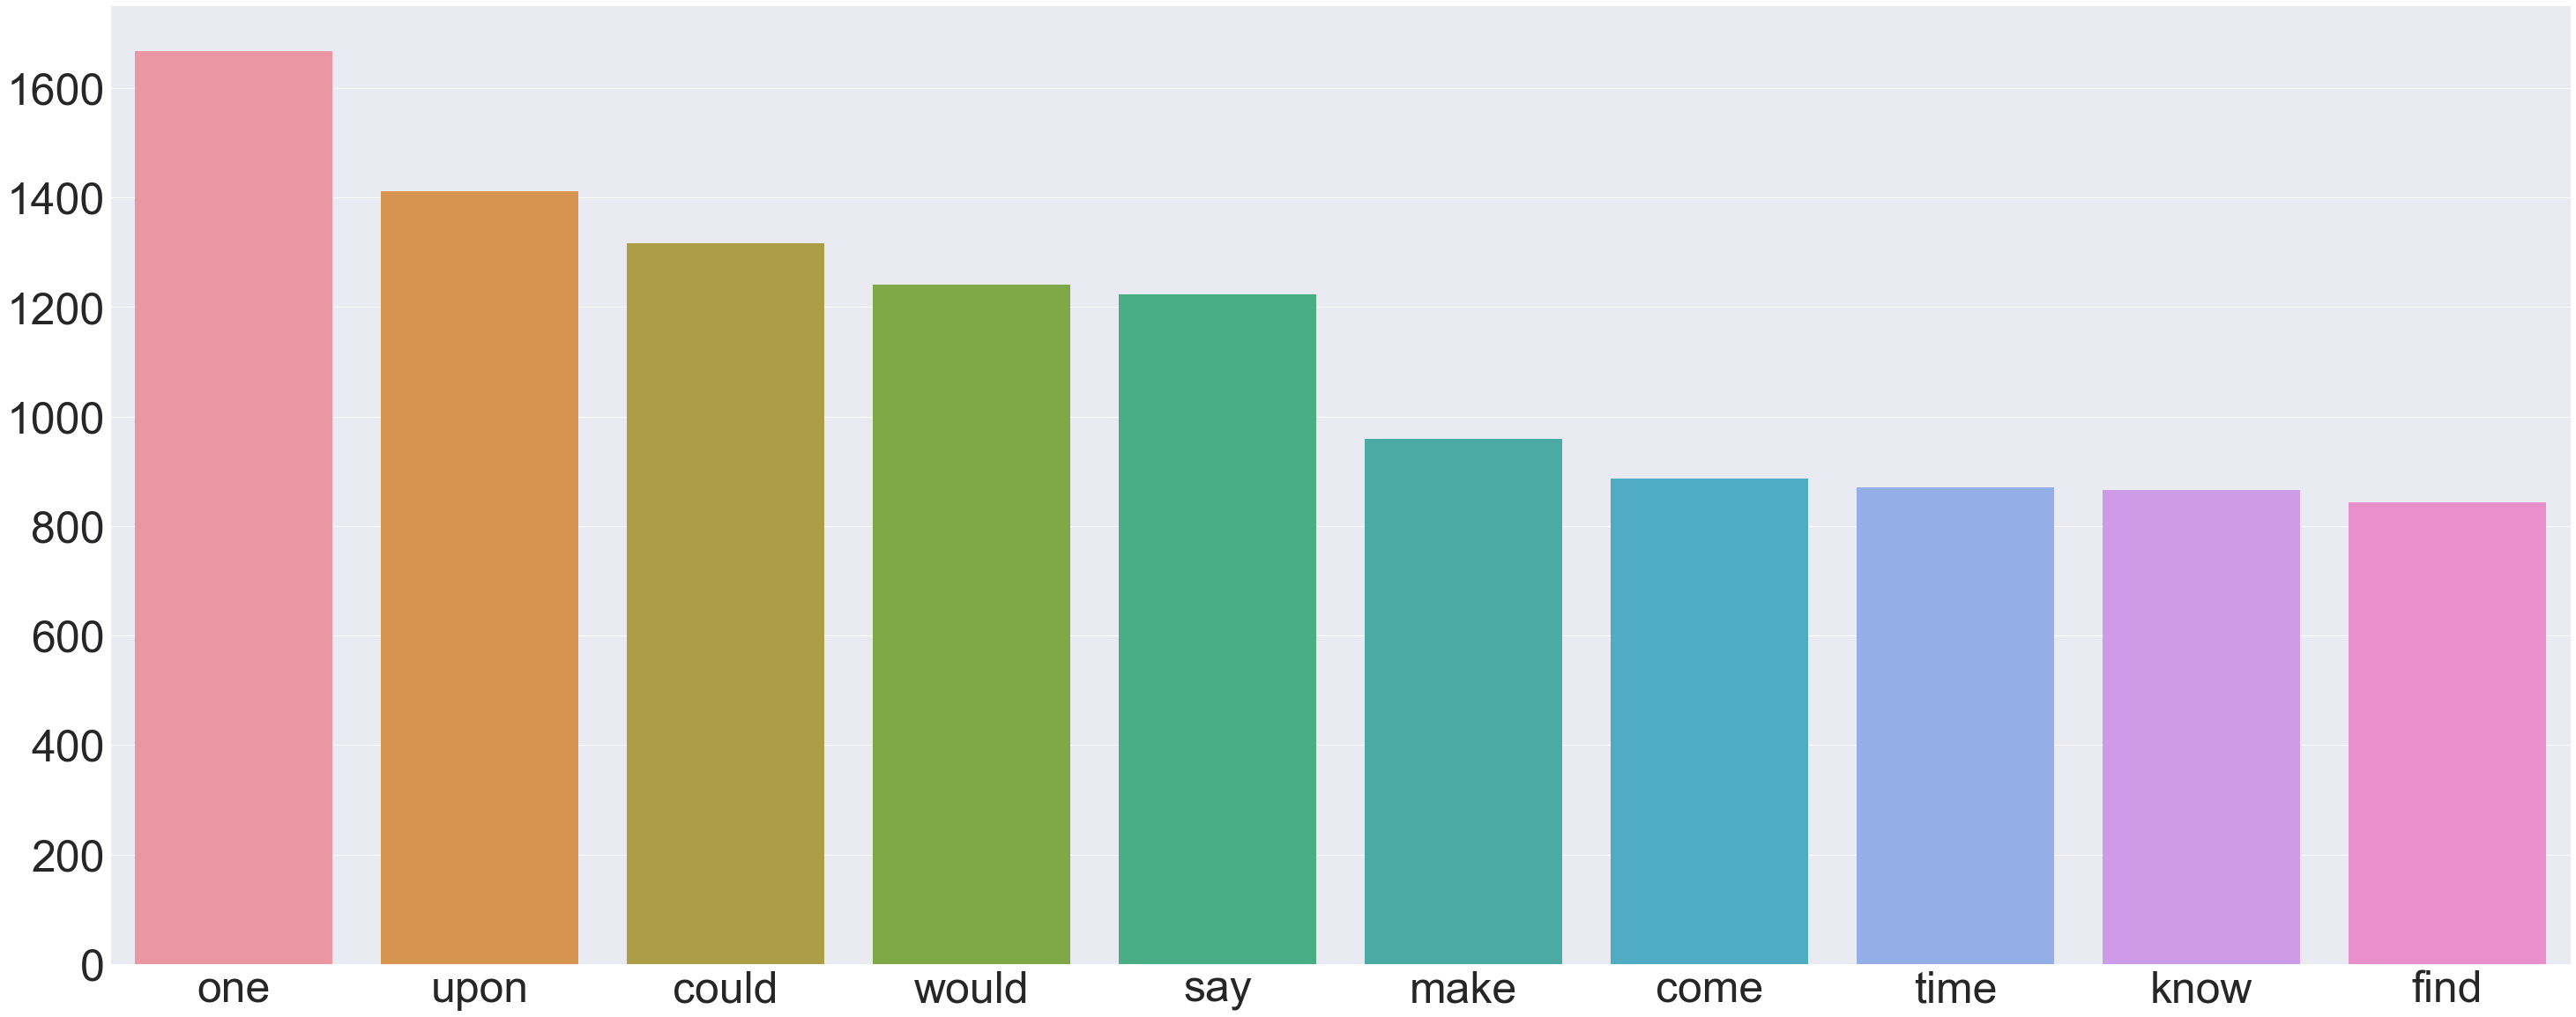

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(50,20)
sns.barplot(x=all_words[0:10].index, y=all_words[0:10])

А най-малко използваните?

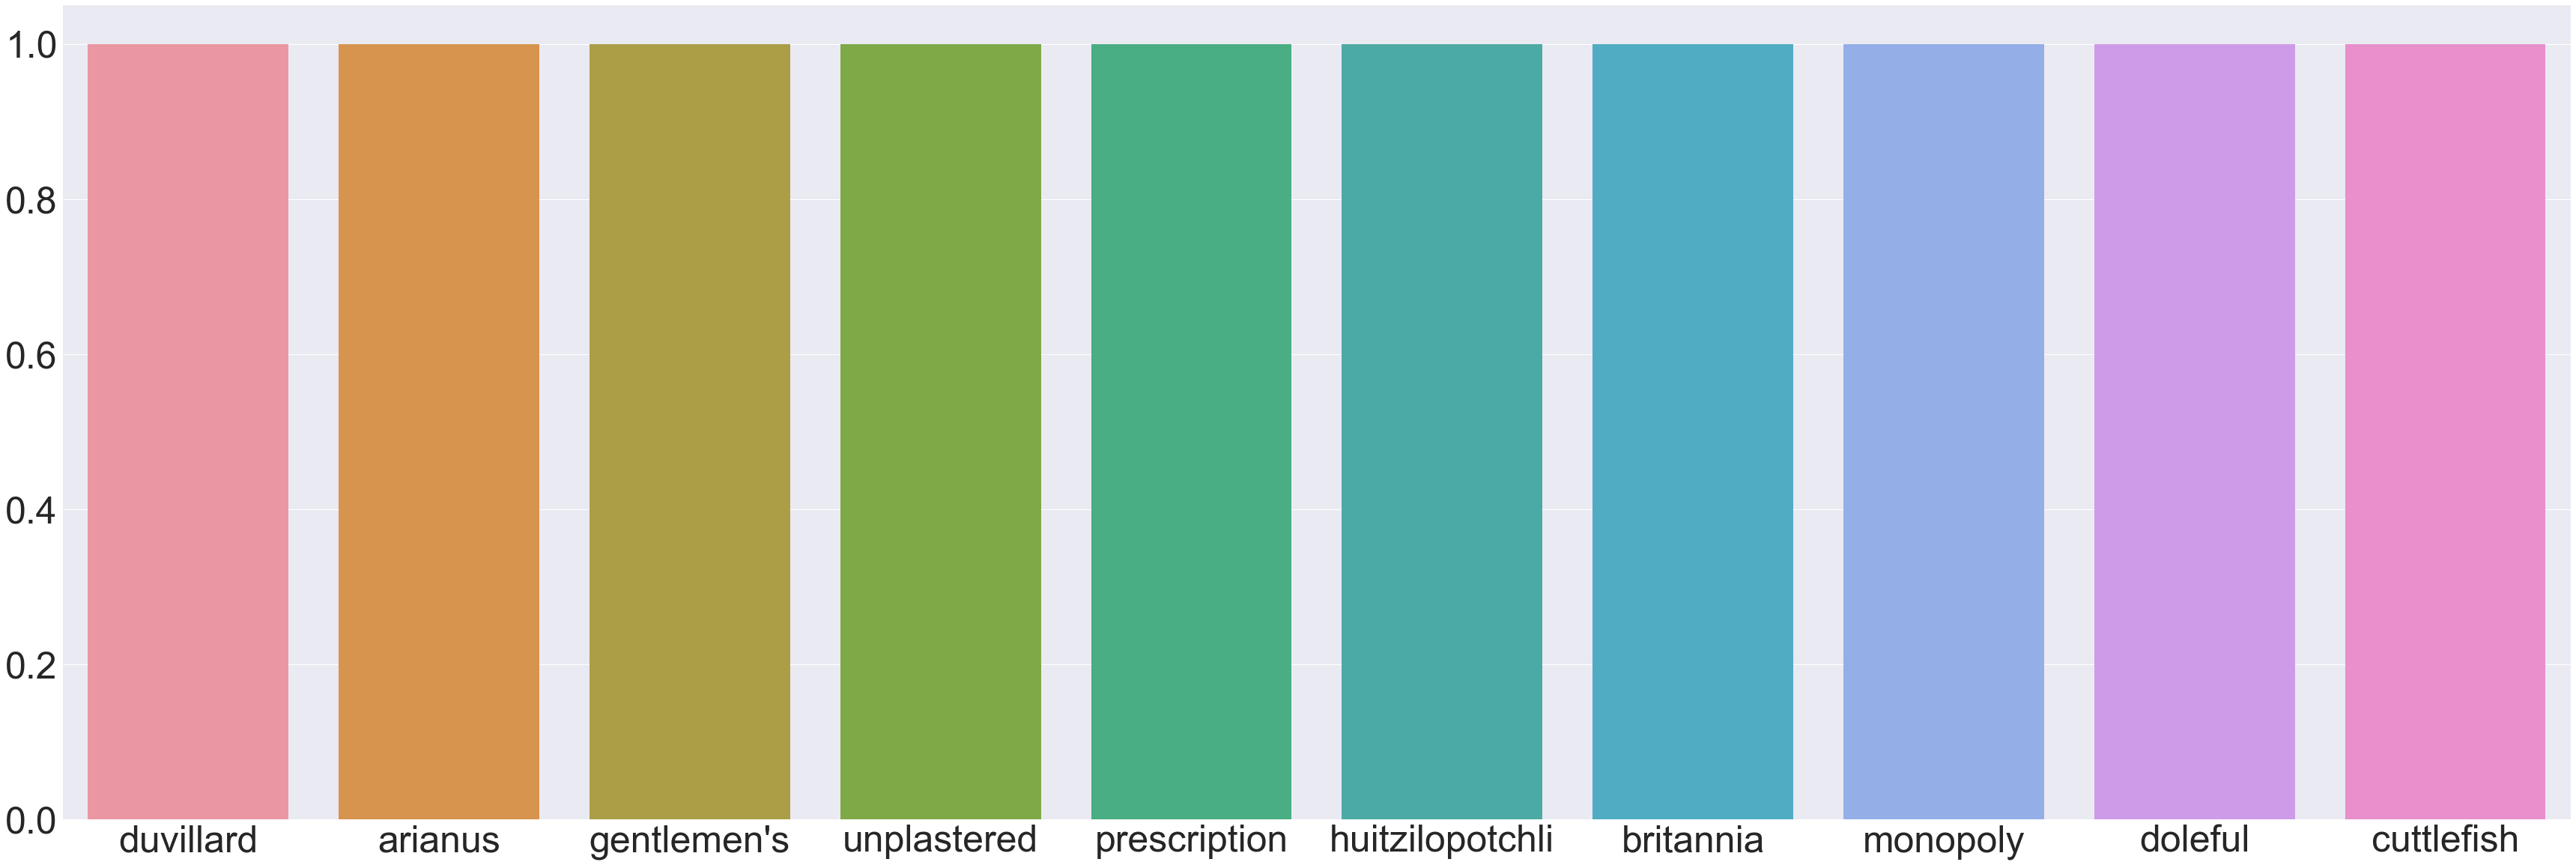

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(60,20)
sns.barplot(x=all_words[-11:-1].index, y=all_words[-11:-1])

<a name='feature'></a>

## Feature engineering

<a name='creative'></a>

### Creative FE

Още първият път, когато видях този data set, силно исках да проверя колко от записите съдържат думата Frankenstein и евентуално да добавя това като feature, защото би бил доста силен feature. Нека най-сетне направя това.

In [14]:
contains_frankenstein = train[train.text.str.contains('frankenstein')].groupby('author')

In [15]:
contains_frankenstein.describe()

text                                                      
       count unique                                       top freq
author                                                            
MWS       19     19  frankenstein doze awake ask cause tumult    1

Едва 19 записа :(

Ще пробвам с друга по-обща дума.

In [16]:
contains_monster = train[train.text.str.contains('monster')].groupby('author')

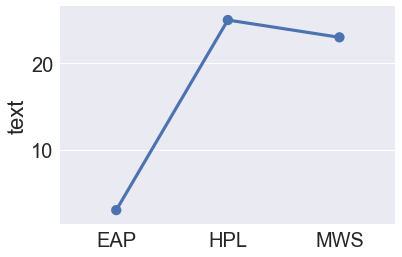

In [17]:
sns.set(font_scale=2)
sns.pointplot(x=contains_monster.count().index.values, y=contains_monster.count().text)

Очаквано предимство за HPL и MWS, но отново твърде малко данни.

Все пак обаче ще направя един трансформатор, който ще образува нови feature-и от тип _contains-word_.

След малко google-ване някои от по-специфичните думи:

In [18]:
specific_words = ["frankenstein",  
                  "cthulhu", 
                  "raymond", 
                  "street", 
                  "adrian", 
                  "ligeia", 
                  "arthur", 
                  "azathot", 
                  "nyarlathotep", 
                  "carter", 
                  "herbert", 
                  "victor",
                  "r'lyeh"]

И сега един много простичък трансформатор, който ще ползвам малко по-късно.

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class ContainsWordsFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, words):
        self.words = words

    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = pd.DataFrame(data)
        new_features_df = pd.DataFrame();
        for word in self.words:
            column_name = "contains_" + word
            new_features_df[column_name] = data.text.apply(lambda x:(word in x))
        return new_features_df

<a name='lda'></a>

### LDA/NMF

[Тази](https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730) статия ми помогна да направя долните неща.

Ще ползвам TfidfVectorizer за NMF и CountVectorizer за LDA

In [20]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf = tfidf_vectorizer.fit_transform(train.text)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

count_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
tf = count_vectorizer.fit_transform(train.text)
count_vectorizer_feature_names = count_vectorizer.get_feature_names()

Здраво copy-paste на параметрите.

In [21]:
no_topics = 10

nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)


Нека видим какво представляват откритите topic-и.

In [22]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
print("NMF TOPICS:")
display_topics(nmf, tfidf_feature_names, no_top_words)
print()
print("LDA TOPICS:")
display_topics(lda, count_vectorizer_feature_names, no_top_words)

NMF TOPICS:
Topic 0:
think time make even yet day find see long take
Topic 1:
say dupin shall nothing little let much sir may dear
Topic 2:
know well nothing don whether though god mean world mistake
Topic 3:
one another two old side every singular small reply end
Topic 4:
could nothing see distinguish believe help perceive word scarcely reason
Topic 5:
would return think alone case permit dare restore reason ask
Topic 6:
upon look fell hand sit throw head subject lay character
Topic 7:
come back whence night still sound men go last home
Topic 8:
thing earth speak every strange tell must like many do
Topic 9:
man old great god young animal dead beard face absent

LDA TOPICS:
Topic 0:
many come feel day let le street fall town may
Topic 1:
never house heart death would become go low way make
Topic 2:
like long come could water seem tree eye deep still
Topic 3:
say may thing must rise tell know dear mother observe
Topic 4:
shall door go get day length three open long arrive
Topic 5:
upon

Почти безсмислени topic-и по мое мнение, но все пак ще ползвам LDA и NMF и ще видя какви резултати ще постигна с тях.

<a name='model'></a>

## Трениране на модели

Време е за действие.

Два FeatureUnion-a(един, когато ползваме LDA, и един за NMF), които да обединият всички feature-и, които правихме досега.

Те няма да бъдат подлагани на GridSearch, защото GridSearch-a започва да става мнооого бавен. 

In [23]:
lda_topics_pipeline = Pipeline([('vectorizer', CountVectorizer(max_df=0.95, min_df=2)),
                                ('topics',LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online', learning_offset=50.))
                               ])

lda_feature_union = FeatureUnion([('contains_word', ContainsWordsFeatureTransformer(specific_words)),
                                  ('topics',lda_topics_pipeline),
                                  ('vectorizer', CountVectorizer(max_df=0.95, min_df=2))
                                 ])

nmf_topics_pipeline = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=2)),
                                ('topics',NMF(n_components=10, alpha=.1, l1_ratio=.5, init='nndsvd'))
                               ])

nmf_feature_union = FeatureUnion([('contains_word', ContainsWordsFeatureTransformer(specific_words)),
                                  ('topics',nmf_topics_pipeline),
                                  ('vectorizer', TfidfVectorizer(max_df=0.95, min_df=2))
                                 ])

Ще пробвам с MultinomialNB и LogisticRegression, защото при Лъчо даваха най-добри резултати :D, а и имат по-малък брой 
хипер-параметри, които да бъдат оптимизирани и това ще направи GS-а една идея по-бърз.

Това съм го изпълнявал само веднъж, защото отне твърде много време.

In [26]:
pipe = Pipeline([('features',lda_feature_union),
                 ('clf',MultinomialNB())
                ])

grid = [
    {
        'clf': [MultinomialNB()],
        'features': [lda_feature_union, nmf_feature_union],
        'clf__alpha':[0.1, 0.3, 0.5, 1, 1,5]
    },
    {
        'clf': [LogisticRegression()],
        'features': [lda_feature_union, nmf_feature_union],
        'clf__C':[0.1, 0.5, 1, 5]
    }
]

search = GridSearchCV(pipe, grid, cv=3, scoring='neg_log_loss')
search.fit(train.text, train.author)

print("Best params:\n{}\n".format(search.best_params_))
print("Best cross-validation score: {:.2f}".format(search.best_score_))

Best params:
{'clf': MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True), 'clf__alpha': 0.1, 'features': FeatureUnion(n_jobs=1,
       transformer_list=[('contains_word', ContainsWordsFeatureTransformer(words=['frankenstein', 'cthulhu', 'raymond', 'street', 'adrian', 'ligeia', 'arthur', 'azathot', 'nyarlathotep', 'carter', 'herbert', 'victor', "r'lyeh"])), ('topics', Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(...
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None))],
       transformer_weights=None)}

Best cross-validation score: -0.47


Ще направя още един GS, но само за MultinomialNB.

Пробвах да прекарам данните и през PCA, но в случая имах sparse данни, затова ползвах TruncatedSVD. И крос валидирах с LogisticRegression, защото MultinomialNB не работи с negative input. Резултатие бяха слаби, а отне много време затова махнах тази крос валидация и само я споменавам сега.

In [26]:
pipe = Pipeline([('features',nmf_feature_union),
                 ('clf', MultinomialNB())
                ])

grid = [
    {
        'clf__alpha':[0.005,0.01, 0.05, 0.1, 0.3],
        'features__vectorizer__ngram_range':[(1,1),(1,2),(1,3),(2,3),(1,4)]
    }
]

search = GridSearchCV(pipe, grid, cv=3, scoring='neg_log_loss')
search.fit(train.text, train.author)

print("Best params:\n{}\n".format(search.best_params_))
print("Best cross-validation score: {:.2f}".format(search.best_score_))

Best params:
{'clf__alpha': 0.05, 'features__vectorizer__ngram_range': (1, 2)}

Best cross-validation score: -0.45


Имаме си фаворит.

In [27]:
nmf_topics_pipeline = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=2)),
                                ('topics',NMF(n_components=10, alpha=.1, l1_ratio=.5, init='nndsvd'))
                               ])

nmf_feature_union = FeatureUnion([('contains_word', ContainsWordsFeatureTransformer(specific_words)),
                                  ('topics',nmf_topics_pipeline),
                                  ('vectorizer', TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,2)))
                                 ])

pipe = Pipeline([('features',nmf_feature_union),
                 ('clf', MultinomialNB(alpha=0.05))
                ])

pipe.fit(train.text, train.author)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('contains_word', ContainsWordsFeatureTransformer(words=['frankenstein', 'cthulhu', 'raymond', 'street', 'adrian', 'ligeia', 'arthur', 'azathot', 'nyarlathotep', 'carter', 'herbert', 'victor', "r'lyeh"])), ('topics', Pipeline(memory...   transformer_weights=None)), ('clf', MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))])

Открадвам фунцкията за чертаене на confusion_matrix-a.

In [28]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

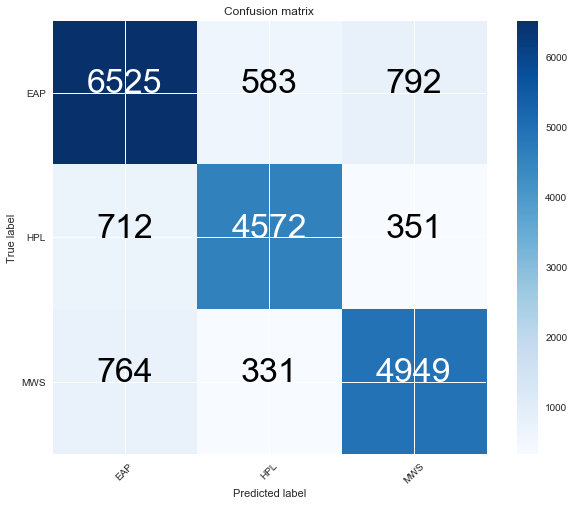

In [29]:
sns.set(font_scale=1)
prediction = cross_val_predict(pipe,train.text, train.author, cv=3)
plot_confusion_matrix(train.author, prediction, classes=pipe.classes_)

Най-проблематичен е класът на EAP. Може би, защото е най-многоброен.

<a name='submit'></a>

## Submission

In [30]:
test = pd.read_csv('data\\test.csv', index_col='id')

In [31]:
test.text = test.text.apply(lambda x:" ".join(tokenizer.tokenize(x.lower().strip()))) 
test.text = test.text.apply(lambda x:" ".join([y for y in x.split() if not y in stop_words]))
test.text = test.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'n') for y in x.split()]))
test.text = test.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'v') for y in x.split()]))
test.text = test.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'a') for y in x.split()]))
test.text = test.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'s') for y in x.split()]))
test.text = test.text.apply(lambda x:" ".join([lmtzr.lemmatize(y,'r') for y in x.split()]))

In [32]:
test.head()

,text
id,
id02310,still urge leave ireland inquietude impatience...
id24541,fire want fan could readily fan newspaper gove...
id00134,break frail door find two cleanly pick human s...
id27757,think possibly manage without one actually tum...
id04081,sure limit knowledge may extend


In [33]:
test_predictions = pipe.predict_proba(test.text)

In [34]:
submit_file = pd.DataFrame(test_predictions, columns=pipe.classes_, index=test.index)
submit_file.head(10)

,EAP,HPL,MWS
id,,,
id02310,0.094911,0.035879,0.869210
id24541,0.875609,0.064011,0.060381
id00134,0.502790,0.471666,0.025544
id27757,0.736583,0.262497,0.000920
id04081,0.820243,0.112623,0.067135
id27337,0.554527,0.432314,0.013160
id24265,0.441041,0.456724,0.102235
id25917,0.086540,0.074293,0.839167
id04951,0.979778,0.019786,0.000436


In [35]:
submit_file.to_csv('data\\submission.csv')

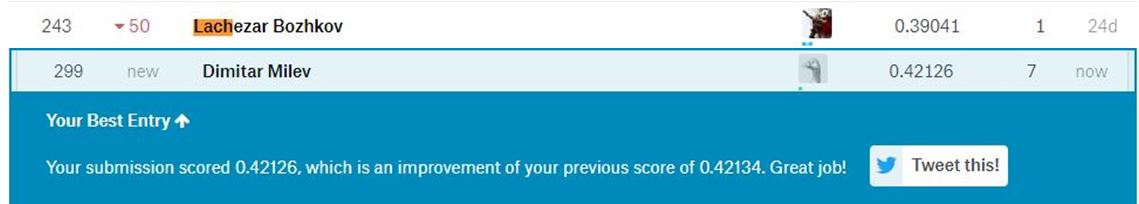

In [36]:
from IPython.display import Image
Image("me_vs_lacho.jpg")

Печално.

<a name='conclusion'></a>

## Заключение

Подходът ми към проблема беше да опитам неща, които Лъчо не направи. Използвах LDA/NMF, добавих нови feature-и, но в крайна сметка моделът ми малко или много наподоби този на Лъчо. Това можеше да се очаква, защото все пак не позлвах кой знае колко различни средства и с този апарат това са максималните резултати. Пробвах и с други модели, които не съм оставил в notebook-a, като например: VotingClassifier; модела базиран само на LDA/NMF feature-ите; модел базиран само на feature измислени от мен, но всеки един от тези се проваляше стабилно. Като цяло съм доволен от това, което постигнах, а и упражних много нови за мен неща.